  \tID                                             Source  \
0    0  https://www.youtube.com/watch?v=UG-KjCSt14k&ab...   
1    1  https://www.patreon.com/JimBrowning/posts?filt...   
2    2  https://www.youtube.com/watch?v=P6dhteJIY48&ab...   
3    3  https://www.youtube.com/watch?v=HlTpousFPsM&ab...   
4    4  https://www.youtube.com/watch?v=8sT121uUFOo&ab...   

                                             Content  Char_Len label  \
0  hi yeah I've got an email here about a laptop ...       224  scam   
1  Hello This is British Telecom technical depart...       398  scam   
2  hello this call is from Interpol the purpose o...       186  scam   
3  hi this is from Amazon customer service we hav...       361  scam   
4  this is calling with the vehicle service depar...       411  scam   

                                       clean_content  
0  hi yeah ive got email laptop didnt order help ...  
1  hello british telecom technical department her...  
2  hello call interpol purpose call

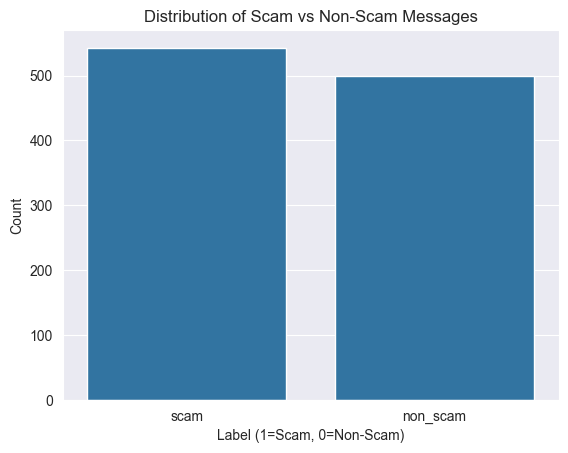

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the preprocessed dataset
df = pd.read_csv('preprocessed_dataset.csv')

# Display the first few rows
print(df.head())

# Check for the 'label' column
if 'label' not in df.columns:
    print("Dataset lacks a 'label' column. Please add labels before proceeding.")
else:
    # Check label distribution
    print(df['label'].value_counts())

    # Visualize label distribution
    sns.countplot(x='label', data=df)
    plt.title('Distribution of Scam vs Non-Scam Messages')
    plt.xlabel('Label (1=Scam, 0=Non-Scam)')
    plt.ylabel('Count')
    plt.show()


In [56]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xxxxx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xxxxx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xxxxx\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [57]:
from azureml.core import Workspace

# Option A: Load from config.json if you have it
# ws = Workspace.from_config()

# Option B: Directly specify parameters
ws = Workspace(
    subscription_id='981464e9-1d1b-429b-ad24-2a615163a59c',
    resource_group='test_llm',
    workspace_name='pavlobondarenko-7274'
)

print(ws.name, ws.resource_group, ws.location, sep='\t')


pavlobondarenko-7274	test_llm	eastus2


In [58]:
import pandas as pd

# Load the balanced dataset
df = pd.read_csv('preprocessed_dataset.csv')

# Display the first few rows
df.head()


,\tID,Source,Content,Char_Len,label,clean_content
0,0,https://www.youtube.com/watch?v=UG-KjCSt14k&ab...,hi yeah I've got an email here about a laptop ...,224,scam,hi yeah ive got email laptop didnt order help ...
1,1,https://www.patreon.com/JimBrowning/posts?filt...,Hello This is British Telecom technical depart...,398,scam,hello british telecom technical department her...
2,2,https://www.youtube.com/watch?v=P6dhteJIY48&ab...,hello this call is from Interpol the purpose o...,186,scam,hello call interpol purpose call inform austri...
3,3,https://www.youtube.com/watch?v=HlTpousFPsM&ab...,hi this is from Amazon customer service we hav...,361,scam,hi amazon customer service seen recent order n...
4,4,https://www.youtube.com/watch?v=8sT121uUFOo&ab...,this is calling with the vehicle service depar...,411,scam,calling vehicle service department calling veh...


\tID             0
Source           0
Content          0
Char_Len         0
label            0
clean_content    0
dtype: int64


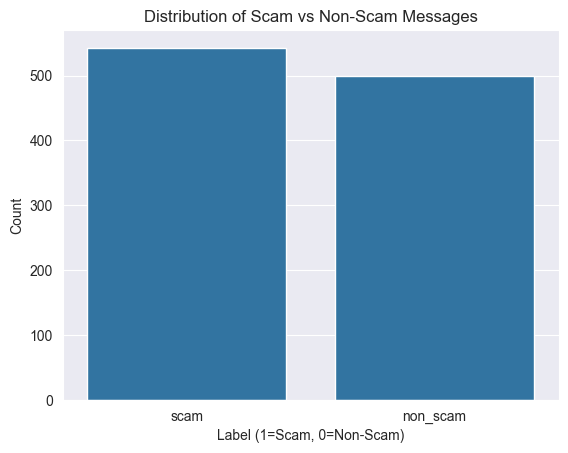

          Char_Len
count  1043.000000
mean    764.504314
std     480.875129
min     104.000000
25%     149.000000
50%     901.000000
75%    1126.500000
max    1556.000000


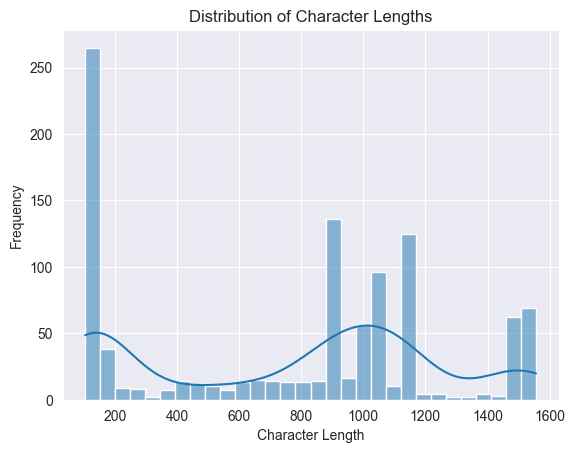

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for missing values
print(df.isnull().sum())

# Distribution of labels
sns.countplot(x='label', data=df)
plt.title('Distribution of Scam vs Non-Scam Messages')
plt.xlabel('Label (1=Scam, 0=Non-Scam)')
plt.ylabel('Count')
plt.show()

# Descriptive statistics
print(df.describe())

# Character length distribution
sns.histplot(df['Char_Len'], bins=30, kde=True)
plt.title('Distribution of Character Lengths')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.show()


In [60]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    words = text.split()
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]
    # Rejoin
    return ' '.join(words)

# Apply preprocessing if not already done
if 'clean_content' not in df.columns:
    df['clean_content'] = df['content'].apply(preprocess_text)


In [61]:
df.to_csv('preprocessed_balanced_dataset.csv', index=False)

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the data
X = tfidf.fit_transform(df['clean_content'])

# Target variable
y = df['label']


In [63]:
import joblib

# Save the TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']

In [64]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print(f"Original distribution: {Counter(y)}")

# If balanced, proceed. Otherwise, apply SMOTE
# Example:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"After SMOTE distribution: {Counter(y_resampled)}")


Original distribution: Counter({'scam': 543, 'non_scam': 500})
After SMOTE distribution: Counter({'scam': 543, 'non_scam': 543})


In [65]:
from sklearn.model_selection import train_test_split

# Check initial data shape before splitting
print("Initial data shape:", X_resampled.shape, y_resampled.shape)

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Verify the shapes of split data
print("Train/Test split shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Check if the test set has data
if X_test.shape[0] == 0 or y_test.shape[0] == 0:
    print("Error: X_test or y_test has zero rows. Please check dataset or adjust test_size.")
else:
    # Continue with model training if data is valid
    # Example: model.fit(X_train, y_train)
    pass


Initial data shape: (1086, 5000) (1086,)
Train/Test split shapes: (868, 5000) (218, 5000) (868,) (218,)


In [66]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Train the model
lr.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [67]:
from sklearn.svm import SVC

# Initialize the model
svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)

# Train the model
svm.fit(X_train, y_train)


SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42)

In [68]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [69]:
from xgboost import XGBClassifier

# Check for NaN values in y_train and y_test
print(y_train.isna().sum())
print(y_test.isna().sum())

# Remove rows with NaN values in y_train and y_test
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()

X_test = X_test[~y_test.isna()]
y_test = y_test.dropna()

# Ensure the mapping is correct
print(y_train.value_counts())
print(y_test.value_counts())

# Initialize the model without the use_label_encoder parameter
xgb_model = XGBClassifier(eval_metric='logloss', scale_pos_weight=1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

0
0
label
non_scam    434
scam        434
Name: count, dtype: int64
label
non_scam    109
scam        109
Name: count, dtype: int64


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['non_scam' 'scam']

Initial data shape: (1086, 5000) (1086,)
Train/Test split shapes: (868, 5000) (218, 5000) (868,) (218,)
y_train unique values after mapping: [0 1]
y_test unique values after mapping: [0 1]
=== Logistic Regression Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       109

    accuracy                           1.00       218
   macro avg       1.00      1.00      1.00       218
weighted avg       1.00      1.00      1.00       218



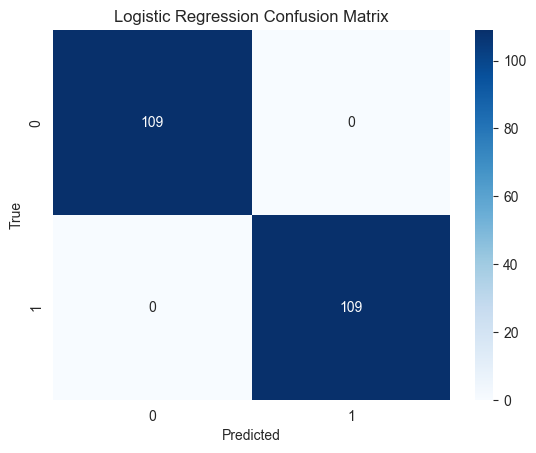

=== SVM Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       109

    accuracy                           1.00       218
   macro avg       1.00      1.00      1.00       218
weighted avg       1.00      1.00      1.00       218



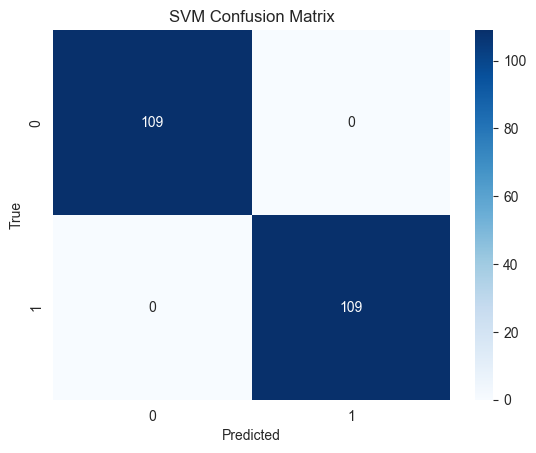

=== Random Forest Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       109

    accuracy                           1.00       218
   macro avg       1.00      1.00      1.00       218
weighted avg       1.00      1.00      1.00       218



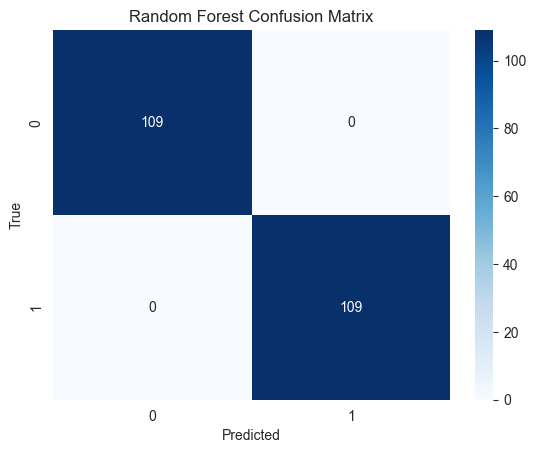

=== XGBoost Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00       109

    accuracy                           1.00       218
   macro avg       1.00      1.00      1.00       218
weighted avg       1.00      1.00      1.00       218



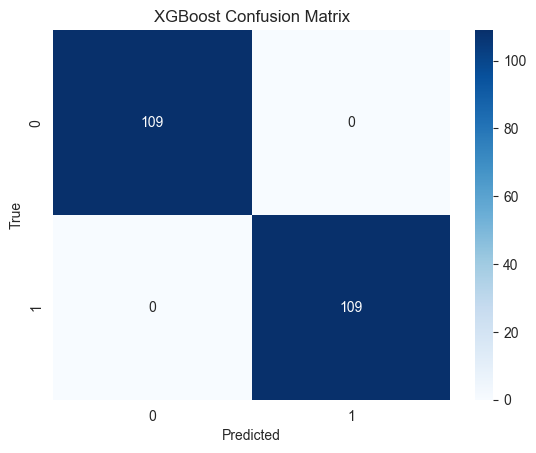

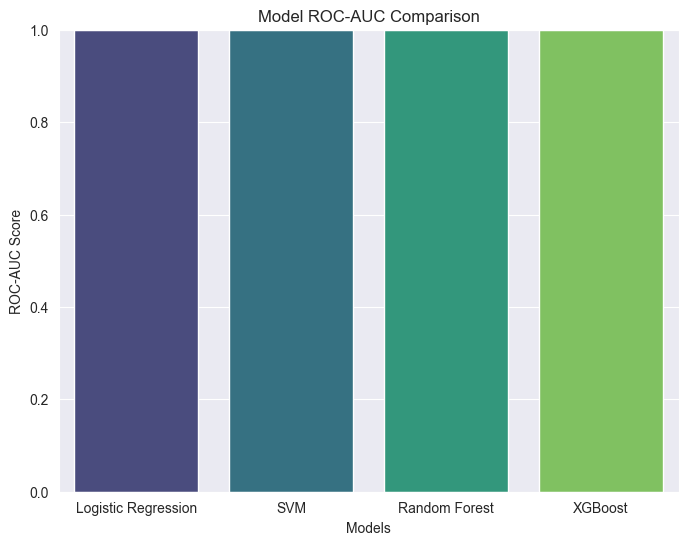

In [54]:
from sklearn.model_selection import train_test_split

# Verify initial data shape before splitting
print("Initial data shape:", X_resampled.shape, y_resampled.shape)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Check shapes of split data
print("Train/Test split shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Map labels to integers before training
y_train = y_train.map({'non_scam': 0, 'scam': 1})
y_test = y_test.map({'non_scam': 0, 'scam': 1})

# Verify the mapping is correct
print("y_train unique values after mapping:", y_train.unique())
print("y_test unique values after mapping:", y_test.unique())

# Retrain models with integer labels
lr.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Evaluate models
roc_auc_lr = evaluate_model(lr, X_test, y_test, "Logistic Regression")
roc_auc_svm = evaluate_model(svm, X_test, y_test, "SVM")
roc_auc_rf = evaluate_model(rf, X_test, y_test, "Random Forest")
roc_auc_xgb = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

# Collect and plot ROC-AUC scores
models = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost']
roc_aucs = [roc_auc_lr, roc_auc_svm, roc_auc_rf, roc_auc_xgb]

# Create a DataFrame for plotting to apply `hue`
import pandas as pd
plot_data = pd.DataFrame({'Model': models, 'ROC-AUC Score': roc_aucs})

# Plot ROC-AUC comparison
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_data, x='Model', y='ROC-AUC Score', hue='Model', dodge=False, palette='viridis', legend=False)
plt.title('Model ROC-AUC Comparison')
plt.ylabel('ROC-AUC Score')
plt.xlabel('Models')
plt.ylim(0, 1)
plt.show()


In [79]:
from sklearn.model_selection import cross_val_score

# Initialize the model (e.g., Logistic Regression)
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model_lr, X, y, cv=5, scoring='f1')

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Average F1 score: {cv_scores.mean():.4f}")


Cross-validation F1 scores: [nan nan nan nan nan]
Average F1 score: nan


C:\Users\xxxxx\Desktop\Hack_Unt\Hack_UNT\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xxxxx\Desktop\Hack_Unt\Hack_UNT\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\xxxxx\Desktop\Hack_Unt\Hack_UNT\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "C:\Users\xxxxx\Desktop\Hack_Unt\Hack_UNT\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\xxxxx\Desktop\Hack_Unt\Hack_UNT\.venv\Lib\site-packages\sklearn\utils\_response.py", line 204, in _get_response_values
    raise ValueError(
ValueError: pos_lab